In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

CP4 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP4.p', 'rb'))
CP25 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP25.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))

In [4]:
print(OBS.keys())

dict_keys(['clon', 'q650', 'w650', 'tmin', 'year', 'p', 't650', 'clat', 'pmean', 'q925', 'u650', 't925', 'v925', 'pmax', 'pgt01isvalid', 'rh925', 'shear', 'u925', 'hour', 'pgt30', 't', 'lon', 'month', 'pv925', 'tmean', 'div925', 'lat', 'area', 'div650', 'rh650', 'v650', 'pv650', 'w925'])


In [5]:
dic = OBS

pp = np.array(dic['pmax'])
sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['u650'])
umax = np.array(dic['u925'])
qq = np.array(dic['q925']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

obs_pcp = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
obs = pd.DataFrame(obs_pcp)

In [25]:
dic.keys()

dict_keys(['shear', 'u925', 'lon', 'month', 'tmin', 'q700', 'tmean', 'area70', 'lat', 'q925', 'u650', 'area'])

In [7]:
dic = CP4

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp4_dic = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*4.4**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp4 = pd.DataFrame(cp4_dic)

In [8]:
dic = CP25

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp25_dic = {
    'prcp' : pp*3600,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*25**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp25 = pd.DataFrame(cp25_dic)

(array([ 27., 123., 233., 261., 222., 194., 136.,  94.,  52.,  20.]),
 array([-95.25037713, -89.92533941, -84.6003017 , -79.27526399,
        -73.95022628, -68.62518856, -63.30015085, -57.97511314,
        -52.65007543, -47.32503771, -42.        ]),
 <a list of 10 Patch objects>)

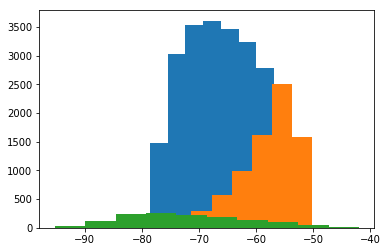

In [9]:
plt.hist(cp4.tmin)
plt.hist(cp25.tmin)
plt.hist(obs.tmin)

In [10]:
obs.shape

(1362, 11)

(0, 150)

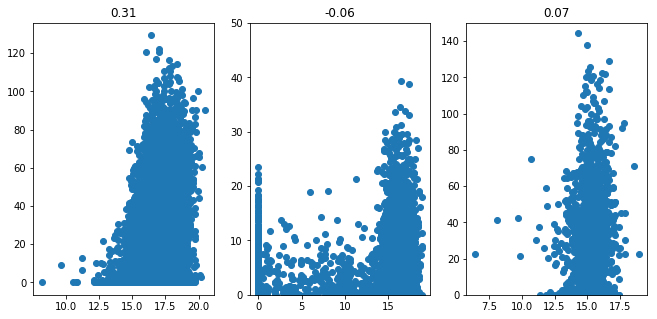

In [11]:
cp4s = [cp4.q925, cp4.prcp]
cp25s = [cp25.q925, cp25.prcp]
obss = [obs.q925, obs.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [12]:
def get_ERA(era, indic):

    dic = {}
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    dic['q_low'] = []
    dic['q_up'] = []
    
    for id, date in enumerate(indic.date):

        getera =np.where((era['time.day']==(indic['date'])[id].day) & (era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        try:
            era_day = era.isel(time=int(getera[0]))
        except TypeError:
            print('Era missing')
            dic['u925'].append(np.nan)
            dic['u650'].append(np.nan)
            dic['q925'].append(np.nan)
            dic['q700'].append(np.nan)

            continue

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['u925'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u650'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=650, method='nearest').values))
        dic['q925'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['q700'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=700, method='nearest').values))

    return dic

In [13]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12))
pdf = pdf.dropna()

ttg = np.array(pdf.tmin, dtype=float)
ttm = np.array(pdf.tmean, dtype=float)
month = pdf.month.values
area = pdf.area.values
area70 = np.array(pdf['70area'], dtype=int)
lat = pdf.clat.values
lon = pdf.clon.values

In [15]:
#era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)

In [16]:
#era_out = get_ERA(era, pdf)
#pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'wb'))

In [14]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'rb'))

In [42]:
pdf

,date,month,year,area,70area,minlon,minlat,maxlon,maxlat,clon,clat,tmin,tmean,t10,t90
1983-02-11_18:00:00_5,1983-02-11 18:00:00,2.0,1983.0,84.0,0.0,-8.569992,5.529999,-7.729996,6.300003,-8.149994,5.915001,-68.659988,-57.395599,-64.319992,-64.319992
1983-02-14_18:00:00_10,1983-02-14 18:00:00,2.0,1983.0,280.0,22.0,-6.259995,5.739998,-4.300003,6.860001,-5.279999,6.299999,-73.169998,-60.815533,-68.659988,-68.659988
1983-02-14_18:00:00_11,1983-02-14 18:00:00,2.0,1983.0,782.0,286.0,-4.229996,6.650002,-1.009995,9.590004,-2.619995,8.120003,-80.009995,-65.006989,-74.809998,-74.809998
1983-02-14_18:00:00_12,1983-02-14 18:00:00,2.0,1983.0,144.0,2.0,-8.429993,7.209999,-6.610001,8.330002,-7.519997,7.770000,-71.659988,-56.381798,-62.970001,-62.970001
1983-02-16_18:00:00_2,1983-02-16 18:00:00,2.0,1983.0,185.0,20.0,-1.360001,5.809998,-0.100006,6.930000,-0.730003,6.369999,-73.169998,-63.902752,-70.089996,-70.089996
1983-02-17_18:00:00_1,1983-02-17 18:00:00,2.0,1983.0,414.0,29.0,-8.569992,4.760002,-5.770004,6.090004,-7.169998,5.425003,-73.169998,-60.206539,-68.659988,-68.659988
1983-02-17_18:00:00_2,1983-02-17 18:00:00,2.0,1983.0,177.0,35.0,-2.479996,5.389999,-0.940002,6.300003,-1.709999,5.845001,-74.809998,-63.201801,-71.659988,-71.659988
1983-02-17_18:00:00_3,1983-02-17 18:00:00,2.0,1983.0,116.0,10.0,5.289993,6.720001,6.270004,7.699997,5.779999,7.209999,-70.089996,-62.256889,-68.659988,-68.659988
1983-02-18_18:00:00_10,1983-02-18 18:00:00,2.0,1983.0,217.0,0.0,-2.899994,6.510002,-1.779999,8.050003,-2.339996,7.280003,-67.019989,-58.657185,-62.970001,-62.970001
1983-02-18_18:00:00_11,1983-02-18 18:00:00,2.0,1983.0,202.0,13.0,3.960007,6.930000,5.430008,7.840004,4.695007,7.385002,-76.529999,-62.504749,-68.659988,-68.659988


In [16]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])

In [17]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : month,
    'area' : area*7.7**2,
    'area70' : area70*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [18]:
ds = ds.dropna()

In [31]:
pos1 = ((ds.month>=9) | (ds.month<=5))  & (ds.u650<0) & (ds.area>=5000) # all storms, without trmm overpass - matchup via storm centre points
opos1 =((obs.month>=9) | (obs.month<=5)) & (obs.u650<0) & (obs.area>=5000) # storms with trmm overpass - matchup via cutout kernels
cpos1 = ((cp4.month>=9) | (cp4.month<=5))  & (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=0)  #cp4
cpos125 = ((cp25.month>=9) | (cp25.month<=5))  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0) # p25

In [32]:
np.sum(cpos1)

19211

In [33]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))
cposi4 = (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=1) & ((cp4.month>=9) | (cp4.month<=5))
cposi25 =(cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0.1) & ((cp25.month>=9) | (cp25.month<=5))

In [34]:
ds_march = ds[pos1]
obs_march = obs[opos1]
cp4_march = cp4[cpos1]
cp25_march = cp25[cpos125]

In [35]:
obsp = obs[oposi]
cp4p = cp4[cposi4]
cp25p = cp25[cposi25]

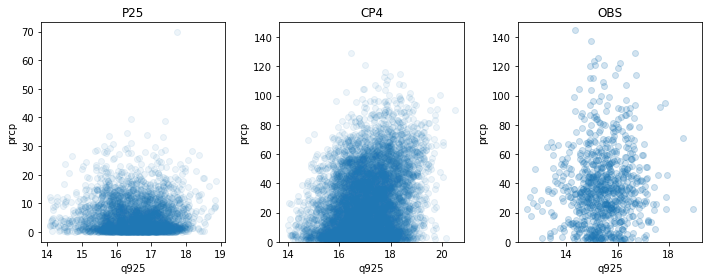

In [27]:
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(131)
plt.xlabel('q925')
plt.ylabel('prcp')
plt.title('P25')
isq = cp25p.q925>14
isqq = cp4p.q925>14
plt.scatter(cp25p.where(isq).q925, cp25p.where(isq).prcp, alpha=0.08)

ax = f.add_subplot(132)
plt.scatter(cp4p.where(isqq).q925, cp4p.where(isqq).prcp, alpha=0.08)
plt.xlabel('q925')
plt.title('CP4')
plt.ylabel('prcp')
ax.set_ylim(0,150)

ax = f.add_subplot(133)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

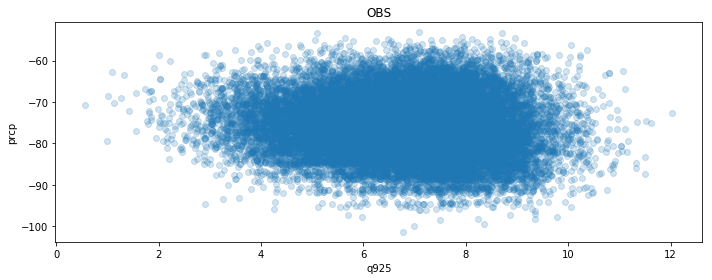

In [39]:
f = plt.figure(figsize=(10,4))
# ax = f.add_subplot(131)
# plt.xlabel('q925')
# plt.ylabel('prcp')
# plt.title('P25')
# isq = cp25p.q925>14
# isqq = cp4p.q925>14
# plt.scatter(cp25p.q925-cp25p.q700, cp25p.tmin, alpha=0.08)

# ax = f.add_subplot(132)
# plt.scatter(cp4p.q925-cp4p.q700, cp4p.tmin, alpha=0.08)
# plt.xlabel('q925')
# plt.title('CP4')
# plt.ylabel('prcp')
# ax.set_ylim(0,150)

ax = f.add_subplot(111)
plt.scatter(ds_march.q700, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

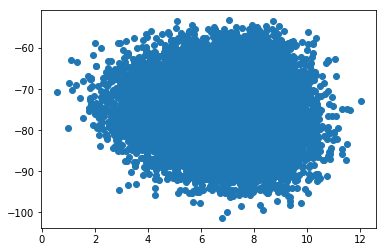

In [66]:
plt.scatter(ds_march.q700, ds_march.tmin)

In [35]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [67]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.q700, dat.tmin, dat.u925)

    mappable = ax2.scatter(dat.q700, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('qmid')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [68]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

pears (0.255769170282489, 0.0)
pears (-0.18504189204529659, 4.803283502841906e-211)
pears (0.24272989324618527, 0.0)
pears (-0.08632142798275355, 8.595223896077429e-47)


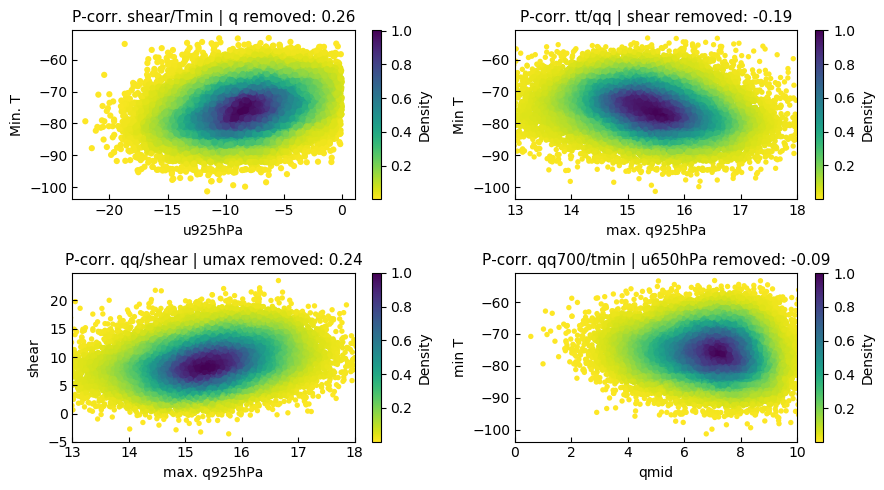

In [69]:
plot_scatter_month(ds_march)

In [39]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=np.percentile(cp4_march.shear,p1)) & (cp4_march.shear<=np.percentile(cp4_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
shear25_march = np.percentile(cp25_march.shear[(cp25_march.shear>=np.percentile(cp25_march.shear,p1)) & (cp25_march.shear<=np.percentile(cp25_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))




abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbq) 
qbinsc_march = np.linspace(np.percentile(cp4_march.q925, p1) , np.percentile(cp4_march.q925, p2), nbq)
qbinsc25_march = np.linspace(15 , np.percentile(cp25_march.q925, p2), nbq)

nbqq = 5
nbss = 5

p1 = 10
p2 = 90

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,1)) & (obsp.shear<=np.percentile(obsp.shear,99))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))
shear_cp4p = np.percentile(cp4p.shear[(cp4p.shear>=np.percentile(cp4p.shear,p1)) & (cp4p.shear<=np.percentile(cp4p.shear,p2))], np.linspace(0,100,nbss)) #np.percentile(cp4p.shear[(cp4p.shear>=8) & (cp4p.shear<=20)], np.linspace(0,100,nbss))
shear_cp25p = np.percentile(cp25p.shear[(cp25p.shear>=np.percentile(cp25p.shear,p1)) & (cp25p.shear<=np.percentile(cp25p.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25p.shear[(cp25p.shear>=8) & (cp25p.shear<=20)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 1) , np.percentile(obsp.q925, 99), nbqq)
qbinsc= np.linspace(np.percentile(cp4p.q925, p1) , np.percentile(cp4p.q925, p2), nbqq)
qbinsc25 = np.linspace(15, np.percentile(cp25p.q925, p2), nbqq)


In [40]:
shear_cp25p

array([ 9.03373322, 12.14674466, 14.16167801, 16.23155976, 19.25791367])

In [41]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 10)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 75)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [42]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [43]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [46]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [47]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [48]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)

In [49]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)

In [50]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [51]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

9.018628486485207
15.340541798957464


In [53]:
ds_mar_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [54]:
cp4_mar_dic = {
    'data' : cp4perc_mar,
    'ybins' : qbinsc_march,
    'xbins' : shearc_march,
    'title' : 'CP4',
    'valid' : cp4val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],1),
    'vmax' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [55]:
cp25_mar_dic = {
    'data' : cp25perc_mar,
    'ybins' : qbinsc25_march,
    'xbins' : shear25_march,
    'title' : 'P25',
    'valid' : cp25val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],1),
    'vmax' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


In [56]:
pcobs[pcobs==0]=np.nan
obsp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : '',
    'valid' : obsval,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc4[pc4==0]=np.nan
cp4_dic = {
    'data' : pc4,
    'ybins' : qbinsc,
    'xbins' : shear_cp4p,
    'title' : '',
    'valid' : cp4val,
    'cbarlabel' : '95th centile p',
    'vmin' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],1),
    'vmax' : np.percentile(pc4[(pc4!=0) & np.isfinite(pc4)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc25[pc25==0]=np.nan
cp25_dic = {
    'data' : pc25,
    'ybins' : qbinsc25,
    'xbins' : shear_cp25p,
    'title' : '',
    'valid' : cp25val,
    'cbarlabel' : '95th centile Max.p',
    'vmin' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],1),
    'vmax' : np.percentile(pc25[(pc25!=0) & np.isfinite(pc25)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

(array([1.000e+00, 2.000e+00, 1.400e+01, 3.600e+01, 1.330e+02, 2.930e+02,
        6.100e+02, 1.196e+03, 2.166e+03, 1.535e+03]),
 array([-65.99490949, -64.40726555, -62.8196216 , -61.23197766,
        -59.64433371, -58.05668977, -56.46904582, -54.88140187,
        -53.29375793, -51.70611398, -50.11847004]),
 <a list of 10 Patch objects>)

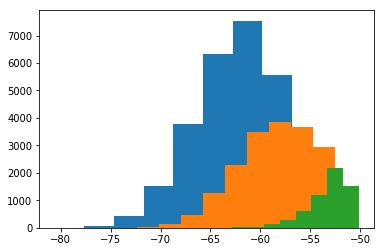

In [57]:
plt.hist(ds_march.tmean)
plt.hist(cp4_march.tmean)
plt.hist(cp25_march.tmean)

In [58]:
data_list = [ds_mar_dic, cp4_mar_dic, cp25_mar_dic,obsp_dic,cp4_dic,cp25_dic]

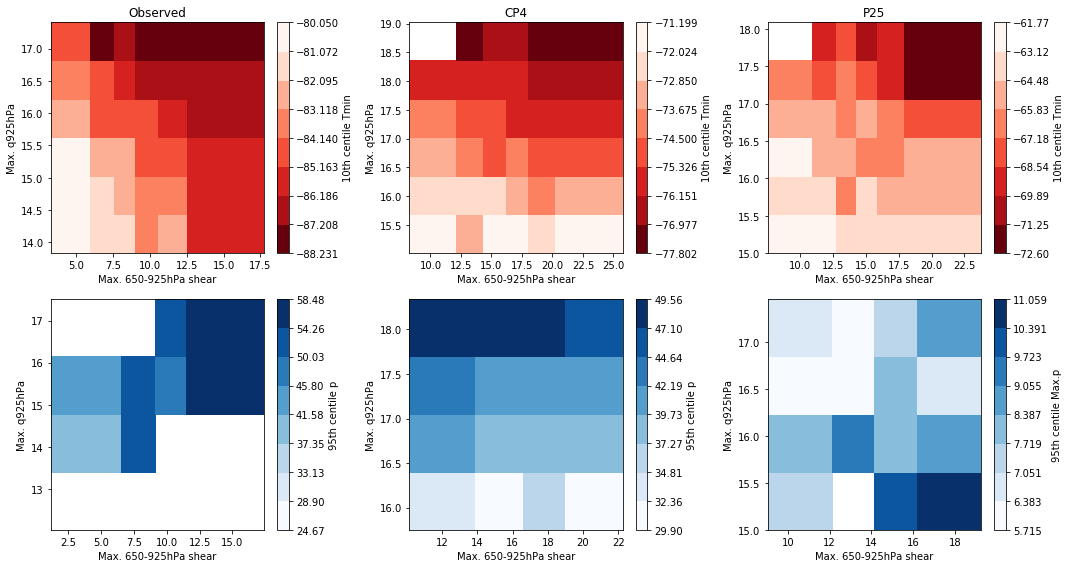

In [59]:
hist2d_six(data_list, valid=True)